In [1]:
import numpy as np
from scipy.io import loadmat
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output

## load training set

In [2]:
data_rand = loadmat("./training_sets/fg/SQ_rand_fg.mat")
data_grid = loadmat("./training_sets/fg/SQ_grid_fg.mat")
parameters_list = data_grid["parameters_list"]
SQ_list = data_grid["SQ_list"][:,1:]

# SQ_list = np.loadtxt('./training_sets/input_grid_all_GPR80.csv',  delimiter=',')[:,:-1]
# parameters_list = np.loadtxt('./training_sets/target_grid_all.csv',  delimiter=',')[:,:-1]

# exclude highest interaction
index_parameters = (parameters_list[:,2]<=20)*(parameters_list[:,0]<=0.405)
parameters_list = parameters_list[index_parameters,:]
SQ_list = SQ_list[index_parameters,:]

print(f"parameters shape: {parameters_list.shape}")
print(f"SQ shape: {SQ_list.shape}")

# rescale the training set SQ to range [0,1]
exp_scale = 6
def f_inp(sq):
    return np.log(sq)/exp_scale/2 + 0.5

# transform the decoder output to SQ
def f_out(sq_pred):
    return np.exp((sq_pred*2-1)*exp_scale) # inverse of f_inp

parameters_mean = np.mean(parameters_list, axis=0)
parameters_std = np.std(parameters_list, axis=0)
print(f"parameters mean: {parameters_mean}")
print(f"parameters std: {parameters_std}")

y_train = f_inp(SQ_list)
x_train = np.array([(parameters_list[:,i]-np.mean(parameters_list[:,i]))/np.std(parameters_list[:,i]) for i in range(3)]).T

def f_params_z(parameters):
    return np.array([(parameters[i]-parameters_mean[i])/parameters_std[i] for i in range(3)])

parameters shape: (13500, 3)
SQ shape: (13500, 99)
parameters mean: [ 0.21  0.26 10.5 ]
parameters std: [0.11683321 0.14422205 5.7662813 ]


## Define NN

In [3]:
# Utility functions
def calculate_output_size(input_size, filter_size, padding, stride):
    return int((input_size - filter_size + 2*padding) / stride + 1)

def to_torch(array):
    return torch.from_numpy(array).float()

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')
def to_torch_device(array,device=cpu):
    return torch.from_numpy(array.astype('float32')).float().to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        m.bias.data.fill_(0.01)

class VAE(nn.Module):
    def __init__(self, latent_dim, sq_dim, n_filters=40):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.sq_dim = sq_dim
        self.n_filters = n_filters
        sq_dim_conv = calculate_output_size(sq_dim, filter_size=3, padding=1, stride=2)

        self.encoder = nn.Sequential(
            nn.Conv1d(1, n_filters, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(sq_dim_conv*n_filters, latent_dim*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, sq_dim_conv*n_filters),
            nn.ReLU(),
            nn.Unflatten(1, (n_filters, sq_dim_conv)),
            nn.ConvTranspose1d(n_filters, n_filters, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(n_filters, 1, kernel_size=3, stride=1, padding=1),
            nn.Flatten()
        )

    def sample(self, eps=None):
        if eps is None:
            eps = torch.randn((1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = torch.chunk(self.encoder(x), 2, dim=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = torch.randn_like(mean)
        return eps * torch.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = torch.sigmoid(logits)
            return probs
        return logits    
    
    def forward(self, x):
        x = x.view(-1, 1, sq_dim)
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z)
        return x_recon


## Train NN

In [4]:
latent_dim = 4  # replace with your actual latent_dim
sq_dim = SQ_list.shape[1]  # replace with your actual sq_dim
n_filters=32

### Train VAE

In [5]:
vae = VAE(latent_dim, sq_dim, n_filters=n_filters)
vae.apply(init_weights)
vae.to(cpu)
# y_train_torch = torch.from_numpy(y_train.astype('float32'))
# vae(y_train_torch[2395:2397])

VAE(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=1600, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=1600, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(32, 50))
    (3): ConvTranspose1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (4): ReLU()
    (5): ConvTranspose1d(32, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): Flatten(start_dim=1, end_dim=-1)
  )
)

In [6]:
def visualize_training_VAE(model, epoch, loss, y_ind):
    y_pred_ind = model(y_ind)
    clear_output(wait=True)
    plt.figure(figsize=(10, 10))
    # for i, idx in enumerate(indices):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        length_y = y_ind.shape[1]
        q = np.arange(length_y)/length_y*20+1/20
        y_train_plot = f_out(y_ind[i].detach().numpy())
        y_pred_plot = f_out(y_pred_ind[i].detach().numpy())
        plt.plot(q,y_train_plot, label='True')
        plt.plot(q,y_pred_plot, label='Predicted')
        plt.ylim([0,3.5])
    plt.legend()
    plt.suptitle(f'Epoch {epoch}, Loss: {loss.item()}')
    plt.show()
    plt.pause(0.001)

def train_model_VAE(model, y_train, epochs=100, batch_size=256, lr=1e-3, l2_reg=0.001):
    # Convert numpy arrays to PyTorch tensors
    # y_train_torch = torch.from_numpy(y_train.astype('float32'))
    y_train_torch = to_torch_device(y_train)

    # Create a DataLoader
    dataset = TensorDataset(y_train_torch, y_train_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define a loss function
    criterion = nn.MSELoss()

    # Define an optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Randomly pick 9 indices for plotting
    np.random.seed(114514)
    indices = np.random.choice(len(y_train), size=9, replace=False)

    lost_list = []
    for epoch in range(epochs):
        for x_batch, y_batch in dataloader:
            # Forward pass: compute predicted y by passing x to the model
            y_pred = model(x_batch)

            # Compute and print loss
            loss = criterion(y_pred, y_batch)
            
            # Add L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_reg * l2_norm

            # Zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        lost_list.append(loss.item())

        # Plot the selected curves
        if epoch % 1 == 0:
            # Print loss for this epoch
            # print(f'Epoch {epoch}, Loss: {loss.item()}')
            
            visualize_training_VAE(model, epoch, loss, y_train_torch[indices])
            plt.figure(figsize=(10, 5))
            plt.plot(lost_list)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.yscale('log')
            # plt.xscale('log')
            plt.show()

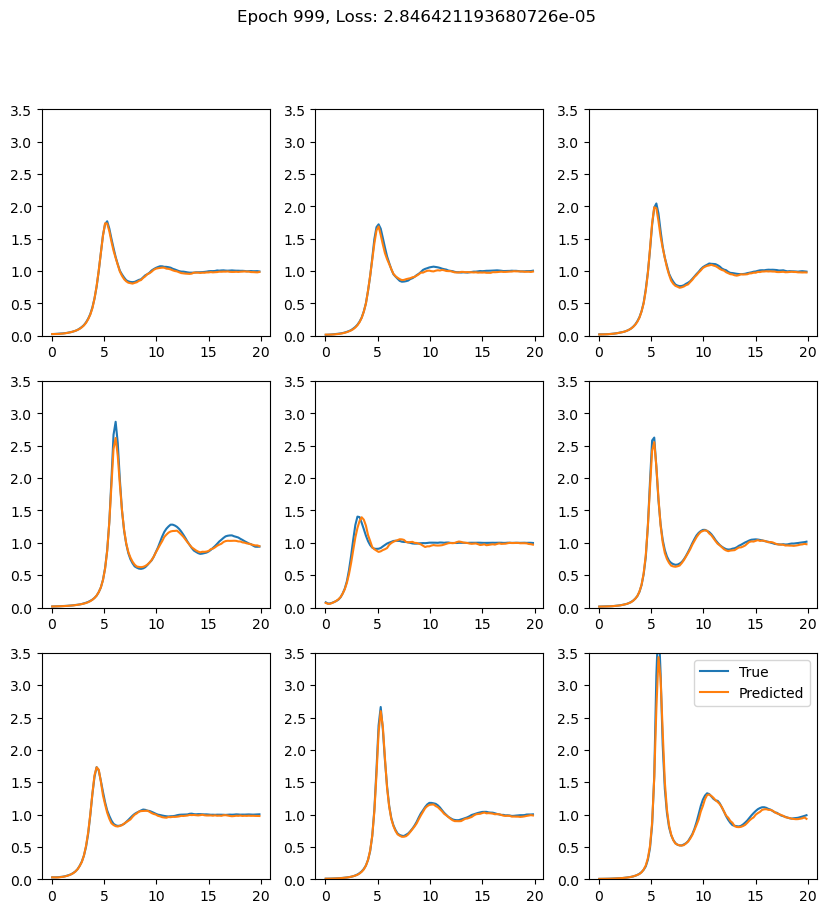

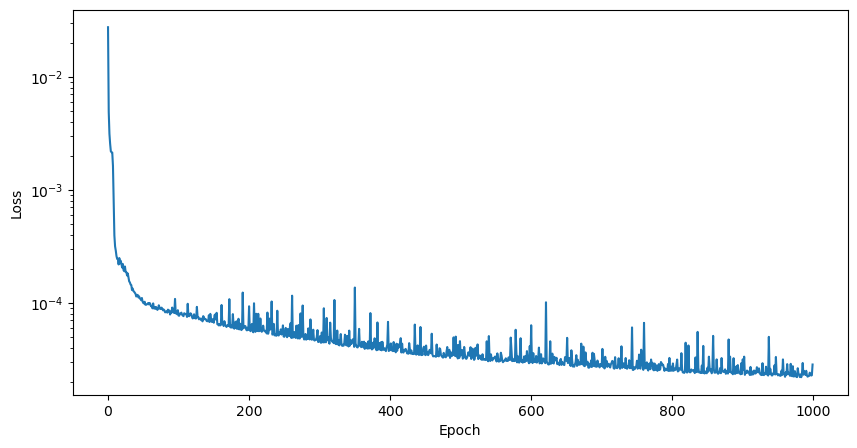

In [7]:
train_model_VAE(vae, y_train, epochs=1000, batch_size=512, l2_reg=1e-6, lr=1e-3)

### Transfer the pretrained decoder

In [8]:
class DecoderAug(nn.Module):
    def __init__(self, latent_dim, sq_dim, n_filters=40):
        super(DecoderAug, self).__init__()
        self.latent_dim = latent_dim
        self.sq_dim = sq_dim
        self.n_filters = n_filters
        sq_dim_conv = calculate_output_size(sq_dim, filter_size=3, padding=1, stride=2)

        self.aug_layers = nn.Sequential(
            nn.Linear(3, latent_dim*2),
            nn.Linear(latent_dim*2, latent_dim*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, sq_dim_conv*n_filters),
            nn.ReLU(),
            nn.Unflatten(1, (n_filters, sq_dim_conv)),
            nn.ConvTranspose1d(n_filters, n_filters, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(n_filters, 1, kernel_size=3, stride=1, padding=1),
            nn.Flatten()
        )
        
    def sample(self, eps=None):
        if eps is None:
            eps = torch.randn((1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = torch.chunk(self.aug_layers(x), 2, dim=2)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = torch.randn_like(mean)
        return eps * torch.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = torch.sigmoid(logits)
            return probs
        return logits   
    
    def forward(self, x):
        x = x.view(-1, 1, 3)
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        z = z.view(-1, latent_dim)
        x_recon = self.decode(z)
        return x_recon

In [9]:
model = DecoderAug(latent_dim, sq_dim, n_filters=n_filters)
model.decoder.load_state_dict(vae.decoder.state_dict())
model.aug_layers.apply(init_weights)
# y_train_torch = torch.from_numpy(y_train.astype('float32'))
# x_train_torch = torch.from_numpy(x_train.astype('float32'))
# model.forward(x_train_torch[2395:2397].view(-1, 1, 3))

Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=8, bias=True)
)

### Train aug layer

In [13]:
def visualize_training(epoch, loss, y_ind, x_ind):
    y_pred_ind = model(x_ind)
    clear_output(wait=True)
    plt.figure(figsize=(10, 10))
    # for i, idx in enumerate(indices):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        length_y = y_ind.shape[1]
        q = np.arange(length_y)/length_y*20+1/20
        y_train_plot = f_out(y_ind[i].detach().numpy())
        y_pred_plot = f_out(y_pred_ind[i].detach().numpy())
        plt.plot(q,y_train_plot, label='True')
        plt.plot(q,y_pred_plot, label='Predicted')
        plt.ylim([0,3.5])
    plt.legend()
    plt.suptitle(f'Epoch {epoch}, Loss: {loss.item()}')
    plt.show()
    plt.pause(0.001)

In [14]:
def train_model(model, x_train, y_train, epochs=100, batch_size=256, lr=1e-3, l2_reg=0.001):
    # Convert numpy arrays to PyTorch tensors
    # x_train_torch = torch.from_numpy(x_train.astype('float32'))
    # y_train_torch = torch.from_numpy(y_train.astype('float32'))
    x_train_torch = to_torch_device(x_train)
    y_train_torch = to_torch_device(y_train)

    # Create a DataLoader
    dataset = TensorDataset(x_train_torch, y_train_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define a loss function
    criterion = nn.MSELoss()

    # Define an optimizer
    optimizer = optim.Adam(model.aug_layers.parameters(), lr=lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Randomly pick 9 indices for plotting
    np.random.seed(114514)
    indices = np.random.choice(len(y_train), size=9, replace=False)

    lost_list = []
    for epoch in range(epochs):
        for x_batch, y_batch in dataloader:
            # Forward pass: compute predicted y by passing x to the model
            y_pred = model(x_batch)

            # Compute and print loss
            loss = criterion(y_pred, y_batch)
            
            # Add L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_reg * l2_norm

            # Zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        lost_list.append(loss.item())

        # Plot the selected curves
        if epoch % 10 == 0:
            # Print loss for this epoch
            # print(f'Epoch {epoch}, Loss: {loss.item()}')
            
            visualize_training(epoch, loss, y_train_torch[indices], x_train_torch[indices])
            plt.figure(figsize=(10, 5))
            plt.plot(lost_list)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.yscale('log')
            # plt.xscale('log')
            plt.show()

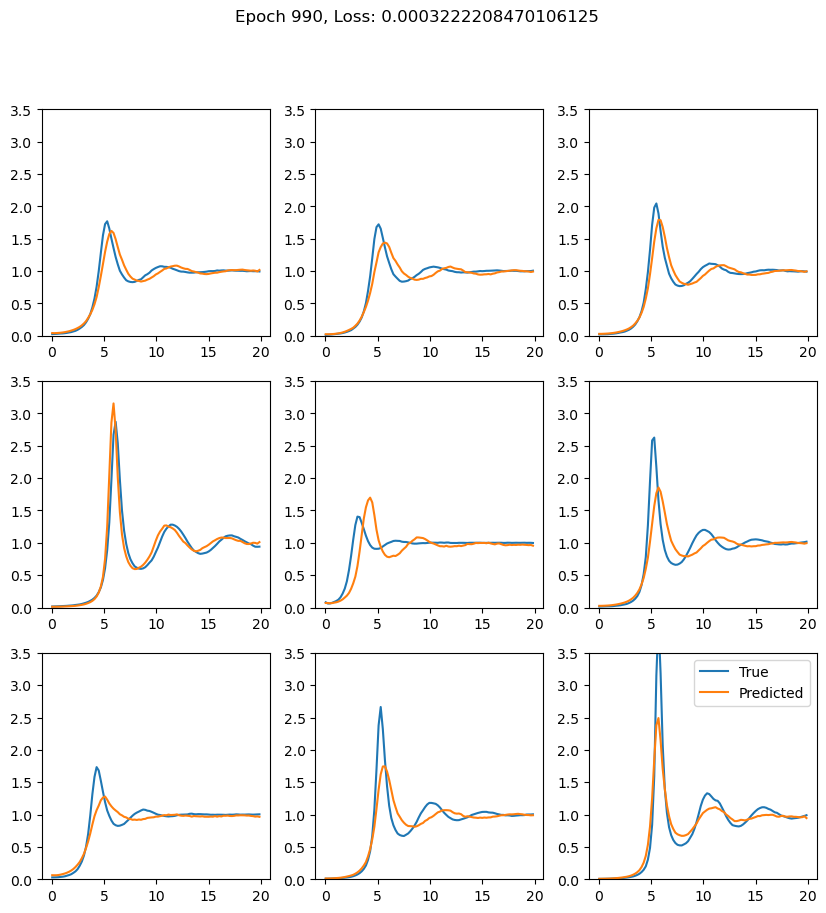

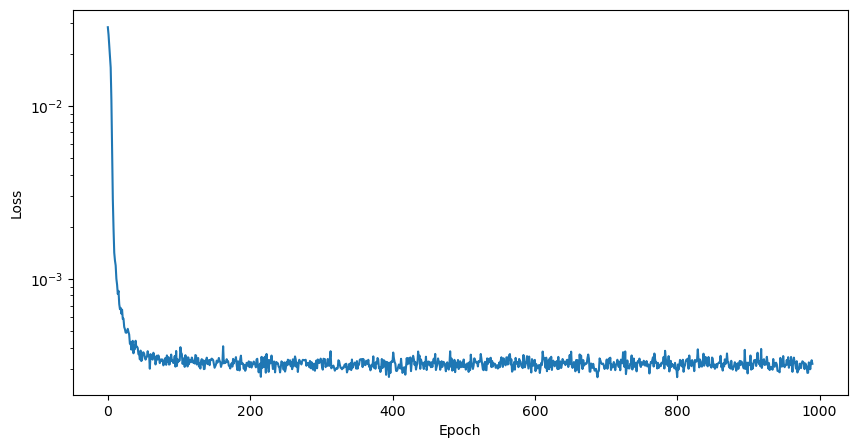

In [12]:
train_model(model, x_train, y_train, epochs=1000, batch_size=256, l2_reg=1e-6, lr=1e-3)

### Train full network

In [11]:
def train_model(model, x_train, y_train, epochs=100, batch_size=256, lr=1e-3, l2_reg=0.001):
    # Convert numpy arrays to PyTorch tensors
    # x_train_torch = torch.from_numpy(x_train.astype('float32'))
    # y_train_torch = torch.from_numpy(y_train.astype('float32'))
    x_train_torch = to_torch_device(x_train)
    y_train_torch = to_torch_device(y_train)

    # Create a DataLoader
    dataset = TensorDataset(x_train_torch, y_train_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define a loss function
    criterion = nn.MSELoss()

    # Define an optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Randomly pick 9 indices for plotting
    np.random.seed(114514)
    indices = np.random.choice(len(y_train), size=9, replace=False)

    lost_list = []
    for epoch in range(epochs):
        for x_batch, y_batch in dataloader:
            # Forward pass: compute predicted y by passing x to the model
            y_pred = model(x_batch)

            # Compute and print loss
            loss = criterion(y_pred, y_batch)
            
            # Add L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_reg * l2_norm

            # Zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        lost_list.append(loss.item())

        # Plot the selected curves
        if epoch % 1 == 0:
            # Print loss for this epoch
            # print(f'Epoch {epoch}, Loss: {loss.item()}')
            
            visualize_training(epoch, loss, y_train_torch[indices], x_train_torch[indices])
            plt.figure(figsize=(10, 5))
            plt.plot(lost_list)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.yscale('log')
            # plt.xscale('log')
            plt.show()

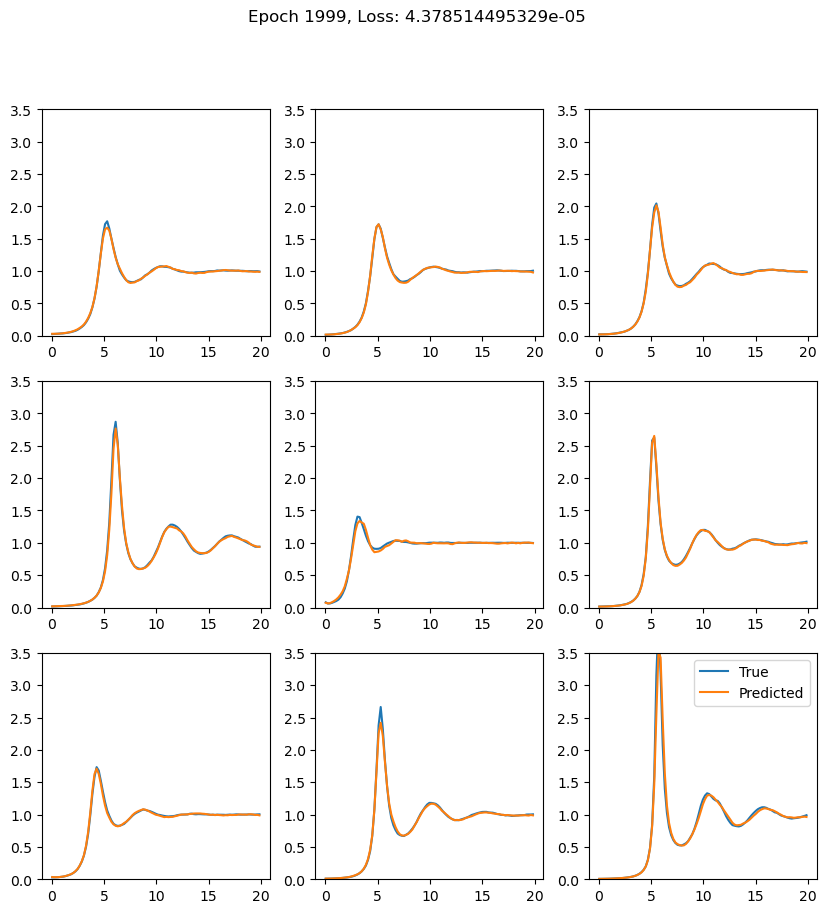

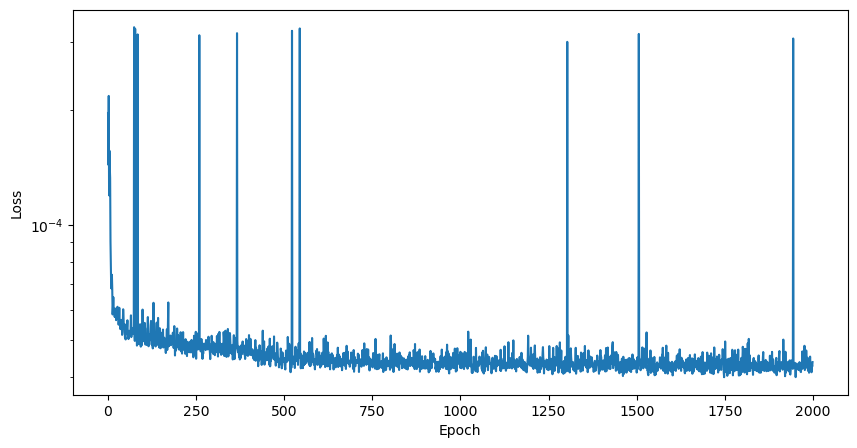

In [14]:
train_model(model, x_train, y_train, epochs=2000, batch_size=128, l2_reg=1e-6, lr=1e-3)
torch.save(model.state_dict(), './saved_model/NN/model_l2.pth')

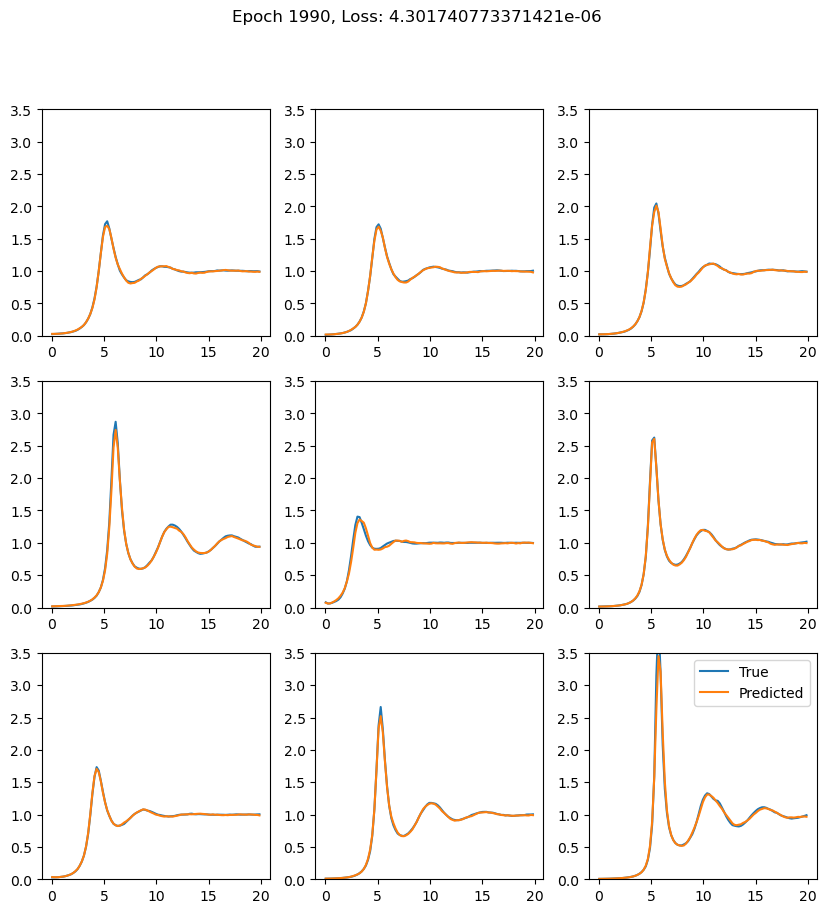

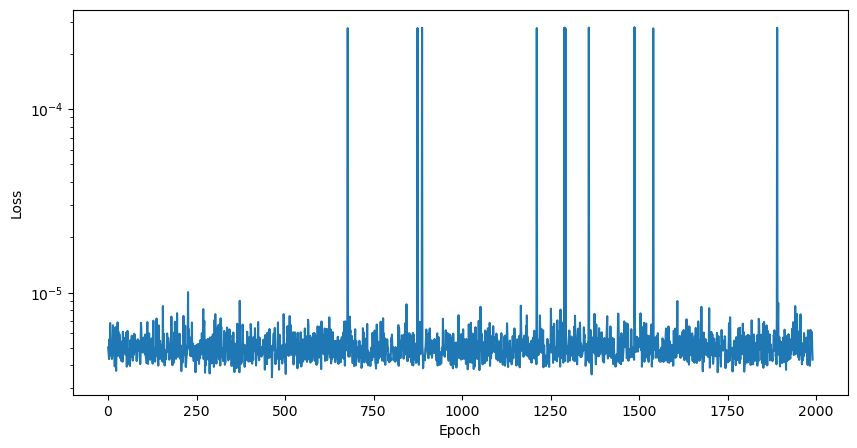

In [15]:
model.load_state_dict(torch.load('./saved_model/NN/model_l2.pth'))
train_model(model, x_train, y_train, epochs=2000, batch_size=64, l2_reg=1e-8, lr=1e-3)
torch.save(model.state_dict(), './saved_model/NN/model_l2-8.pth')

In [17]:
# model = DecoderAug(latent_dim, sq_dim, n_filters=32)
# model.load_state_dict(torch.load('./saved_model/NN/model_l2.pth'))

<All keys matched successfully>